## Make dataloaders

In [1]:
# ablationA: 'ProtT5_XL_UniRef50' + 'esm2_t33_650M_UR50D'
import h5py
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch, os, collections
import pandas as pd
import pickle5 as pickle
from tqdm import tqdm

# Load guide csv file
df = pd.read_csv('data/LigID_pdbchain_partitions.csv')
# Load data pkl file
with open('data/multi_ion.pkl', 'rb') as f:
    data_dict = pickle.load(f)

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
fields = ['CA','CO','CU','FE2','FE','MG','MN','PO4','SO4','ZN', 'null']
batch_size=64
prottrans_emb_ = data_path+'protT5/output/per_residue_embeddings.h5'
prottrans_emb = h5py.File(prottrans_emb_, 'r')

model_names = ['ProtT5_XL_UniRef50', 'esm2_t33_650M_UR50D']

for i in range(1,7):
    emb_batch, batch_id, file_no = [], 0, 0
    label_dict = {k: [] for k in fields}
    batch_pdbids = []
    df_fold = df[df['partitions']==i]
    for pdbid in tqdm(df_fold.pdbchain):
        if file_no<batch_size:
            try:
                emb_A = torch.from_numpy(np.array(prottrans_emb.get(pdbid)))
                emb_B = torch.load(data_path+model_names[1]+'/'+pdbid+'.pt')
                key = list(emb_B['representations'].keys())
                emb_B = emb_B['representations'][key[0]]

                emb = torch.cat((emb_A, emb_B), 1)
                for ion in fields:
                    if ion in data_dict[pdbid]['ions'].keys():
                        labels = [int(a) for a in data_dict[pdbid]['ions'][ion]]
                        label_dict[ion].append(labels)
                    else:
                        label_dict[ion].append([0]*len(emb))
                emb_batch.append(emb)
                batch_pdbids.append(pdbid)
                file_no+=1
                batch_id+=1
            except:
                pass
        else:
            emb_batch_ = torch.cat(emb_batch)
            for ion in label_dict.keys():
                label_dict[ion] = np.array([item for sublist in label_dict[ion] for item in sublist])
            null_label = np.ones(len(emb_batch_))   # Add null label
            for ion in label_dict.keys(): 
                null_label[np.where(label_dict[ion]==1)[0]]=0
            label_dict['null']=null_label

            # Generate dict for storing data
            batch_dict = dict.fromkeys(['pdbids', 'embs', 'labels'])
            batch_dict['pdbids'] = batch_pdbids
            batch_dict['embs'] = emb_batch_
            batch_dict['labels'] = label_dict

            with open(data_path+'ablationA_multiclass_batch64_CV/'+str(batch_id)+'_fold%s'%(i)+'.pickle', 'wb') as handle:
                pickle.dump(batch_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
            # Reinitaialize variables for next batch
            label_dict = {k: [] for k in fields}
            batch_pdbids, emb_batch, file_no = [], [], 0 
        break

    break

100%|██████████| 3002/3002 [04:11<00:00, 11.93it/s]


In [8]:
# ablationB: 'ProtT5_XL_UniRef50' + 'dssp'
import h5py
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch, os, collections
import pandas as pd
import pickle5 as pickle
from tqdm import tqdm

# Load guide csv file
df = pd.read_csv('data/LigID_pdbchain_partitions.csv')
# Load data pkl file
with open('data/multi_ion.pkl', 'rb') as f:
    data_dict = pickle.load(f)

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
fields = ['CA','CO','CU','FE2','FE','MG','MN','PO4','SO4','ZN', 'null']
batch_size=64
prottrans_emb_ = data_path+'protT5/output/per_residue_embeddings.h5'
prottrans_emb = h5py.File(prottrans_emb_, 'r')

model_names = ['ProtT5_XL_UniRef50', 'dssp']
print('Generating batches for AblationB')
for i in range(1,7):
    emb_batch, batch_id, file_no = [], 0, 0
    label_dict = {k: [] for k in fields}
    batch_pdbids = []
    df_fold = df[df['partitions']==i]
    for pdbid in tqdm(df_fold.pdbchain):
        if file_no<batch_size:
            try:
                emb_A = torch.from_numpy(np.array(prottrans_emb.get(pdbid)))
                emb_B = torch.from_numpy(np.load('data/dssp_dataset/dssp/%s_dssp.npy'%(pdbid))) 
                
                #key = list(emb_B['representations'].keys())
                #emb_B = emb_B['representations'][key[0]]

                emb = torch.cat((emb_A, emb_B), 1)
                for ion in fields:
                    if ion in data_dict[pdbid]['ions'].keys():
                        labels = [int(a) for a in data_dict[pdbid]['ions'][ion]]
                        label_dict[ion].append(labels)
                    else:
                        label_dict[ion].append([0]*len(emb))
                emb_batch.append(emb)
                batch_pdbids.append(pdbid)
                file_no+=1
                batch_id+=1
            except:
                pass
        else:
            emb_batch_ = torch.cat(emb_batch)
            for ion in label_dict.keys():
                label_dict[ion] = np.array([item for sublist in label_dict[ion] for item in sublist])
            null_label = np.ones(len(emb_batch_))   # Add null label
            for ion in label_dict.keys(): 
                null_label[np.where(label_dict[ion]==1)[0]]=0
            label_dict['null']=null_label

            # Generate dict for storing data
            batch_dict = dict.fromkeys(['pdbids', 'embs', 'labels'])
            batch_dict['pdbids'] = batch_pdbids
            batch_dict['embs'] = emb_batch_
            batch_dict['labels'] = label_dict

            with open(data_path+'ablationB_multiclass_batch64_CV/'+str(batch_id)+'_fold%s'%(i)+'.pickle', 'wb') as handle:
                pickle.dump(batch_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
            # Reinitaialize variables for next batch
            label_dict = {k: [] for k in fields}
            batch_pdbids, emb_batch, file_no = [], [], 0 

Generating batches for AblationB


100%|██████████| 3002/3002 [01:47<00:00, 27.93it/s]


In [6]:
# ablationC: 'esm2_t33_650M_UR50D' + 'dssp'
import h5py
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch, os, collections
import pandas as pd
import pickle5 as pickle
from tqdm import tqdm

# Load guide csv file
df = pd.read_csv('data/LigID_pdbchain_partitions.csv')
# Load data pkl file
with open('data/multi_ion.pkl', 'rb') as f:
    data_dict = pickle.load(f)

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
fields = ['CA','CO','CU','FE2','FE','MG','MN','PO4','SO4','ZN', 'null']
batch_size=64
prottrans_emb_ = data_path+'protT5/output/per_residue_embeddings.h5'
prottrans_emb = h5py.File(prottrans_emb_, 'r')

model_names = ['esm2_t33_650M_UR50D', 'dssp']
print('Generating batches for AblationB')
for i in range(1,7):
    emb_batch, batch_id, file_no = [], 0, 0
    label_dict = {k: [] for k in fields}
    batch_pdbids = []
    df_fold = df[df['partitions']==i]
    for pdbid in tqdm(df_fold.pdbchain):
        if file_no<batch_size:
            try:
                emb_A = torch.load(data_path+model_names[0]+'/'+pdbid+'.pt')
                key = list(emb_A['representations'].keys())
                emb_A = emb_A['representations'][key[0]]
                emb_B = torch.from_numpy(np.load('data/dssp_dataset/dssp/%s_dssp.npy'%(pdbid))) 

                emb = torch.cat((emb_A, emb_B), 1)
                for ion in fields:
                    if ion in data_dict[pdbid]['ions'].keys():
                        labels = [int(a) for a in data_dict[pdbid]['ions'][ion]]
                        label_dict[ion].append(labels)
                    else:
                        label_dict[ion].append([0]*len(emb))
                emb_batch.append(emb)
                batch_pdbids.append(pdbid)
                file_no+=1
                batch_id+=1
            except:
                pass
        else:
            emb_batch_ = torch.cat(emb_batch)
            for ion in label_dict.keys():
                label_dict[ion] = np.array([item for sublist in label_dict[ion] for item in sublist])
            null_label = np.ones(len(emb_batch_))   # Add null label
            for ion in label_dict.keys(): 
                null_label[np.where(label_dict[ion]==1)[0]]=0
            label_dict['null']=null_label

            # Generate dict for storing data
            batch_dict = dict.fromkeys(['pdbids', 'embs', 'labels'])
            batch_dict['pdbids'] = batch_pdbids
            batch_dict['embs'] = emb_batch_
            batch_dict['labels'] = label_dict

            with open(data_path+'ablationC_multiclass_batch64_CV/'+str(batch_id)+'_fold%s'%(i)+'.pickle', 'wb') as handle:
                pickle.dump(batch_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
            # Reinitaialize variables for next batch
            label_dict = {k: [] for k in fields}
            batch_pdbids, emb_batch, file_no = [], [], 0 

Generating batches for AblationB


100%|██████████| 3002/3002 [04:14<00:00, 11.80it/s]


In [9]:
# ablationD: 'esm2_t33_650M_UR50D'+ ProtT5_XL_UniRef50 + 'dssp'
import h5py
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch, os, collections
import pandas as pd
import pickle5 as pickle
from tqdm import tqdm

# Load guide csv file
df = pd.read_csv('data/LigID_pdbchain_partitions.csv')
# Load data pkl file
with open('data/multi_ion.pkl', 'rb') as f:
    data_dict = pickle.load(f)

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
fields = ['CA','CO','CU','FE2','FE','MG','MN','PO4','SO4','ZN', 'null']
batch_size=64
prottrans_emb_ = data_path+'protT5/output/per_residue_embeddings.h5'
prottrans_emb = h5py.File(prottrans_emb_, 'r')

model_names = ['esm2_t33_650M_UR50D', 'ProtT5_XL_UniRef50', 'dssp']
print('Generating batches for AblationD')
for i in range(1,7):
    emb_batch, batch_id, file_no = [], 0, 0
    label_dict = {k: [] for k in fields}
    batch_pdbids = []
    df_fold = df[df['partitions']==i]
    for pdbid in tqdm(df_fold.pdbchain):
        if file_no<batch_size:
            try:
                emb_A = torch.load(data_path+model_names[0]+'/'+pdbid+'.pt')
                key = list(emb_A['representations'].keys())
                emb_A = emb_A['representations'][key[0]]
                emb_B = torch.from_numpy(np.array(prottrans_emb.get(pdbid)))
                emb_C = torch.from_numpy(np.load('data/dssp_dataset/dssp/%s_dssp.npy'%(pdbid))) 

                emb = torch.cat((emb_A, emb_B, emb_C), 1)
                for ion in fields:
                    if ion in data_dict[pdbid]['ions'].keys():
                        labels = [int(a) for a in data_dict[pdbid]['ions'][ion]]
                        label_dict[ion].append(labels)
                    else:
                        label_dict[ion].append([0]*len(emb))
                emb_batch.append(emb)
                batch_pdbids.append(pdbid)
                file_no+=1
                batch_id+=1
            except:
                pass
        else:
            emb_batch_ = torch.cat(emb_batch)
            for ion in label_dict.keys():
                label_dict[ion] = np.array([item for sublist in label_dict[ion] for item in sublist])
            null_label = np.ones(len(emb_batch_))   # Add null label
            for ion in label_dict.keys(): 
                null_label[np.where(label_dict[ion]==1)[0]]=0
            label_dict['null']=null_label

            # Generate dict for storing data
            batch_dict = dict.fromkeys(['pdbids', 'embs', 'labels'])
            batch_dict['pdbids'] = batch_pdbids
            batch_dict['embs'] = emb_batch_
            batch_dict['labels'] = label_dict

            with open(data_path+'ablationD_multiclass_batch64_CV/'+str(batch_id)+'_fold%s'%(i)+'.pickle', 'wb') as handle:
                pickle.dump(batch_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
                
            # Reinitaialize variables for next batch
            label_dict = {k: [] for k in fields}
            batch_pdbids, emb_batch, file_no = [], [], 0 

Generating batches for AblationB


100%|██████████| 3002/3002 [13:32<00:00,  3.69it/s]


In [4]:
data_path+model_names[0]+'/'+pdbid+'.pt'

'/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/esm2_t33_650M_UR50D/8xim_A.pt'

## Training

In [2]:
from utils import train_loop, ProtEmbDataset, ProtEmbDatasetCV, ProtEmbDataset_dssp, ProtEmbDataset_ablation
import torch
import warnings
from torch.utils.data import Dataset, DataLoader
import numpy as np
from models import IonicProtein
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import os
from tqdm import tqdm
import pandas as pd

from torch.utils.data import Dataset, DataLoader
import pickle5 as pickle
from sklearn.metrics import f1_score, average_precision_score
import torch.nn.functional as F
from tqdm import trange

kfolds = 5
data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

model_list = ['ablationA']

fields = ['CA','CO','CU','FE2','FE','MG','MN','PO4','SO4','ZN', 'null']

for model_name in model_list:
    print('Starting training for %s...'%(model_name))
    for fold in range(1,kfolds+1):
        #count = 0
        print('Training fold', fold)
        train_batches, test_batches = [], []   
        for datapoint in os.listdir(data_path+model_name+'_multiclass_batch64_CV/'):
            if datapoint.endswith('fold%s.pickle'%(fold)):
                test_batches.append(datapoint)
            elif datapoint.endswith('fold6.pickle'):
                pass
            else:
                train_batches.append(datapoint)
        
        data_list = np.array(os.listdir(data_path+model_name+'_multiclass_batch64_CV/'))
        train_indices = list(np.where(np.isin(data_list, train_batches))[0])
        test_indices = list(np.where(np.isin(data_list, test_batches))[0])

        protein_dataset = ProtEmbDataset_ablation(model_name)
        
        sampler_train = SubsetRandomSampler(train_indices)
        sampler_val = SubsetRandomSampler(test_indices)
        dataloader_train = DataLoader(protein_dataset, batch_size=1, sampler = sampler_train, num_workers=4)
        dataloader_val = DataLoader(protein_dataset, batch_size=1, sampler = sampler_val, num_workers=4)
        print('Dataset lengths (train/val):', len(dataloader_train), len(dataloader_val))

        warnings.filterwarnings("ignore")

        model = IonicProtein(dataloader_train.dataset[0][0].shape[1]).to(device)
        #print(model)
        criterion_1 = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(10))
        epochs = 30
        lr = 0.001
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        lrsched = torch.optim.lr_scheduler.StepLR(optimizer, 10)
        print('\nTraining model (%s) %s for % epochs at %s learning rate'%('Fold'+str(fold), model_name, epochs, lr))
        net_loss_train, net_f1_train, net_loss_test, net_f1_test = train_loop(model, epochs, dataloader_train, dataloader_val, optimizer, lrsched, criterion_1, 100)
        training_stats = pd.DataFrame()
        training_stats['net_loss_train'] = net_loss_train
        training_stats['net_loss_test']  = net_loss_test
        training_stats['net_f1_train']   = net_f1_train
        training_stats['net_f1_test']    = net_f1_test
        training_stats.to_csv('checkpoints_multiclass_weighted_v2/%s_setB_fold%s.csv'%(model_name, str(fold)))
        torch.save(model.state_dict(), 'checkpoints_multiclass_weighted_v2/%s_setB_fold%s.pt'%(model_name, str(fold)))
        del model
    break

Device: cuda
Starting training for ablationA...
Training fold 1
431
Dataset lengths (train/val): 308 79

Training model (Fold1) ablationA for  3.000000e+01pochs at 0.001 learning rate


  0%|          | 0/308 [03:45<?, ?batch/s]


KeyboardInterrupt: 

: 

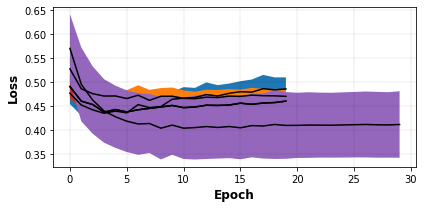

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

model_list = ['ablationA', 'ablationB', 'ablationC', 'ablationC', 'esm2_t33_650M_UR50D']
fig, ax = plt.subplots(1, figsize=(6,3))
for model_name in model_list:
    list_f1, list_loss = [], []
    for fold in range(1,6):
        df = pd.read_csv('checkpoints_multiclass_weighted_v2/%s_setB_fold%s.csv'%(model_name, fold))
        # list_f1.append(list(df['net_f1_test']))
        list_loss.append(list(df['net_loss_test']))

    # test_mean_f1 = np.mean(list_f1, axis=0)
    # test_std_f1 = np.std(list_f1, axis=0)

    test_mean_loss = np.mean(list_loss, axis=0)
    test_std_loss = np.std(list_loss, axis=0)

    
    # ax[0].plot(range(len(test_mean_f1)), test_mean_f1, label="Training score", color="black")
    # ax[0].fill_between(range(len(test_mean_f1)), test_mean_f1 - test_std_f1, test_mean_f1 + test_std_f1, color="dimgrey")
    # ax[0].set_ylabel('F1 score', fontsize=12, fontweight='bold')
    # ax[0].grid(color='black', linestyle='-.', linewidth=0.1)

    ax.plot(range(len(test_mean_loss)), test_mean_loss, label="Training score", color="black")
    ax.fill_between(range(len(test_mean_loss)), test_mean_loss - test_std_loss, test_mean_loss + test_std_loss)
    ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.grid(color='black', linestyle='-.', linewidth=0.1)

    #ax.set_title('[%s]\n5-fold CV statistics (test set)'%(model_name), fontsize=12, fontweight='bold')
plt.tight_layout()

# Validation on fold6

In [ ]:
import pickle5 as pickle
from models import IonicProtein
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,matthews_corrcoef
import torch
import torch.nn as nn
m = nn.Sigmoid()

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
model_name = 'ablationA'

cpt_fold = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

preds_sig_merged, preds_bin_merged, labels_merged = [], [], []
for fold_batch in tqdm(os.listdir(data_path+model_name+'_multiclass_batch64_CV')):
    if fold_batch.endswith('6.pickle'):
        # for ion in fields:
        #     ion_index = fields.index(ion)   # Index of the ion under consideration
        #     if ion=='null':
        #         continue

        with open(data_path+model_name+'_multiclass_batch64_CV/'+fold_batch, 'rb') as handle:
            datapoint = pickle.load(handle)
        
        embs = datapoint['embs']
        labels = torch.from_numpy(np.array(list(datapoint['labels'].values())))

        trained_model = IonicProtein(embs.shape[1]).to(device)
        trained_model.load_state_dict(torch.load('checkpoints_multiclass_weighted_v2/%s_setB_fold%s.pt'%(model_name, cpt_fold)))
        trained_model.eval()

        predictions = trained_model(embs.to(device), mask=None)
        predictions_sigmoid = m(torch.stack(predictions))
        predictions_binary = torch.round(predictions_sigmoid)

        preds_sig_merged.append(predictions_sigmoid)
        preds_bin_merged.append(predictions_binary)
        labels_merged.append(labels.T)

        del embs, labels, trained_model, predictions, predictions_sigmoid, predictions_binary

preds_sig_merged = torch.cat(preds_sig_merged)
preds_bin_merged = torch.cat(preds_bin_merged)
labels_merged = torch.cat(labels_merged)                         

In [8]:
labels_merged.shape, embs_merged.shape

device = 'cpu'
trained_model = IonicProtein(embs_merged.shape[1]).to(device)
trained_model.load_state_dict(torch.load('checkpoints_multiclass_weighted_v2/%s_setB_fold%s.pt'%(model_name, cpt_fold)))
trained_model.eval()

predictions = trained_model(embs_merged.to(device), mask=None)
predictions_sigmoid = m(torch.stack(predictions))
predictions_binary = torch.round(predictions_sigmoid)

In [1]:
predictions

NameError: name 'predictions' is not defined

In [52]:
labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0', dtype=torch.float64)

431
ablationA
330
ablationB
343
ablationC
330
ablationD


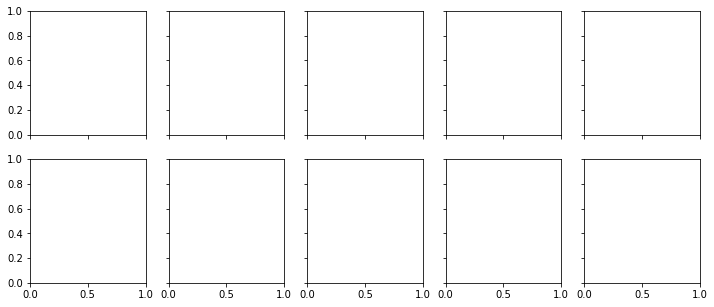

In [1]:
# External validation of fold 6 
# All labels considered (nx11)
import torch
from models import IonicProtein
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from utils import train_loop, ProtEmbDataset, ProtEmbDatasetCV, ProtEmbDataset_dssp, ProtEmbDataset_ablation
import torch.utils.data as data
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import collections
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import h5py
import pickle5 as pickle
import os

import torch.nn as nn
m = nn.Sigmoid()

cpt_fold = 1

data_path = '/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/'
fields = ['CA','CO','CU','FE2','FE','MG','MN','PO4','SO4','ZN', 'null']
label_dict = dict.fromkeys(fields, [])
# inference_dict = dict.fromkeys(df[df['partitions']==6]['pdb_chain'].values)

#figure, axes = plt.subplots(2,5, figsize=(12,5), sharey=True, sharex=True)
#axes_ = axes.flatten()

model_list = ['ProtT5_XL_UniRef50', 'esm2_t33_650M_UR50D']
prottrans_emb_ = data_path+'protT5/output/per_residue_embeddings.h5'
prottrans_emb = h5py.File(prottrans_emb_, 'r')

df = pd.read_csv('data/LigID_pdbchain_partitions.csv')
with open('data/multi_ion.pkl', 'rb') as f:
    data_dict = pickle.load(f)

#for model_name in model_list:
# ablationA: 'ProtT5_XL_UniRef50' + 'esm2_t33_650M_UR50D'
# ablationB: 'ProtT5_XL_UniRef50' + 'dssp'
# ablationC: 'esm2_t33_650M_UR50D' + 'dssp'
# ablationD: 'esm2_t33_650M_UR50D'+ ProtT5_XL_UniRef50 + 'dssp'
ablations = ['ablationA', 'ablationB', 'ablationC', 'ablationD']

for model_name in ablations:
    perf_dict = {k: [] for k in fields}
    # Prepare holdout_set
    holdout_batches = []
    holdout_fold = 6
    for datapoint in os.listdir(data_path+model_name+'_multiclass_batch64_CV/'):
        if datapoint.endswith('fold%s.pickle'%(holdout_fold)):
            holdout_batches.append(datapoint)
        else:
            pass

    data_list = np.array(os.listdir(data_path+model_name+'_multiclass_batch64_CV/'))
    holdout_indices = list(np.where(np.isin(data_list, holdout_batches))[0])
    protein_dataset = ProtEmbDataset_ablation(model_name)
    sampler_holdout = SubsetRandomSampler(holdout_indices)
    dataloader_holdout = DataLoader(protein_dataset, batch_size=1, sampler = sampler_holdout, num_workers=4)

    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = 'cpu'      # For inference
    trained_model = IonicProtein(dataloader_holdout.dataset[0][0].shape[1]).to(device)
    trained_model.load_state_dict(torch.load('checkpoints_multiclass_weighted_v2/%s_setB_fold%s.pt'%(model_name, cpt_fold)))
    trained_model.eval()
    
    print(model_name)
    for ion in fields:
        ion_index = fields.index(ion)   # Index of the ion under consideration
        if ion=='null':
            continue
        embs_merged, labels_merged = [], []
        for pdbid in df[df['partitions']==6]['pdbchain'].values: # Run inference on partition 6
            if ion in data_dict[pdbid]['ions'].keys():
                try:
            #if data_dict[pdbid][2]==ion:   # Ion wise segregation of holdout set
                    if model_name=='ablationA':
                        emb_A = torch.from_numpy(np.array(prottrans_emb.get(pdbid)))
                        emb_B = torch.load(data_path+model_list[1]+'/'+pdbid+'.pt')
                        key = list(emb_B['representations'].keys())
                        emb_B = emb_B['representations'][key[0]]
                        emb = torch.cat((emb_A, emb_B), 1)
                    elif model_name=='ablationB':
                        emb_A = torch.from_numpy(np.array(prottrans_emb.get(pdbid)))
                        emb_B = torch.from_numpy(np.load('data/dssp_dataset/dssp/%s_dssp.npy'%(pdbid))) 
                        emb = torch.cat((emb_A, emb_B), 1)
                    elif model_name=='ablationC':
                        emb_A = torch.load(data_path+model_list[1]+'/'+pdbid+'.pt')
                        key = list(emb_A['representations'].keys())
                        emb_A = emb_A['representations'][key[0]]
                        emb_B = torch.from_numpy(np.load('data/dssp_dataset/dssp/%s_dssp.npy'%(pdbid))) 
                        emb = torch.cat((emb_A, emb_B), 1)
                    elif model_name=='ablationD':
                        emb_A = torch.load(data_path+model_list[1]+'/'+pdbid+'.pt')
                        key = list(emb_A['representations'].keys())
                        emb_A = emb_A['representations'][key[0]]
                        emb_B = torch.from_numpy(np.array(prottrans_emb.get(pdbid)))
                        emb_C = torch.from_numpy(np.load('data/dssp_dataset/dssp/%s_dssp.npy'%(pdbid))) 
                        emb = torch.cat((emb_A, emb_B, emb_C), 1)
                        
                    embs_merged.append(emb)

                    # Initalize label_array
                    label_list = [int(a) for a in data_dict[pdbid]['ions'][ion]]
                    label_array = np.array([[0]*len(emb)]*len(fields))
                    null_label = np.ones(len(label_list))
                    null_label[np.where(label_list==1)[0]]=0

                    # populate label_array
                    label_array[ion_index] = label_list
                    label_array[10]=null_label
                    label_array = torch.from_numpy(label_array)
                    labels_merged.append(label_array.T)
                except:
                    pass

        embs_merged = torch.cat(embs_merged)
        labels_merged = torch.cat(labels_merged)
        predictions = trained_model(embs_merged.to(device), mask=None)
        
        predictions_sigmoid = m(torch.stack(predictions))
        predictions_binary = torch.round(predictions_sigmoid)
        
        mcc_flattened = matthews_corrcoef(labels_merged.T.flatten().cpu().detach().numpy(),
                                            predictions_binary.flatten().cpu().detach().numpy())
        
        mcc_sliced = matthews_corrcoef(labels_merged.T[ion_index].cpu().detach().numpy(),
                                        predictions_binary[ion_index].cpu().detach().numpy())

        roc_auc = roc_auc_score(labels_merged.T[ion_index].cpu().data.numpy(),
                                predictions_sigmoid[ion_index].cpu().data.numpy())
        fpr, tpr, threshold = roc_curve(labels_merged.T[ion_index].cpu().data.numpy(), 
                                        predictions_sigmoid[ion_index].cpu().data.numpy())
        precision, recall, thresholds = precision_recall_curve(labels_merged.T[ion_index].cpu().data.numpy(), 
                                                            predictions_sigmoid[ion_index].cpu().data.numpy())
        aupr = average_precision_score(labels_merged.T[ion_index].cpu().data.numpy(), 
                                        predictions_sigmoid[ion_index].cpu().data.numpy())

        perf_stats = {'fpr':fpr, 'tpr':tpr, 'auroc':roc_auc, 'mcc':mcc_sliced, 'aupr':aupr,
                'precision':precision, 'recall':recall}
        perf_dict[ion] = perf_stats

    with open('results/'+model_name+'_multi_perf.pickle', 'wb') as handle:
        pickle.dump(perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# ablationA: 'ProtT5_XL_UniRef50' + 'esm2_t33_650M_UR50D'
# ablationB: 'ProtT5_XL_UniRef50' + 'dssp'
# ablationC: 'esm2_t33_650M_UR50D' + 'dssp'
# ablationD: 'esm2_t33_650M_UR50D'+ ProtT5_XL_UniRef50 + 'dssp'

'/media/dell4/a87d4a0b-5641-40d3-8d10-416948fc2996/ION_DATA/protT5/output/per_residue_embeddings.h5'